<a href="https://colab.research.google.com/github/rsaxby/_flower_classifier/blob/master/Flower_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torchvision
from torchvision import models, transforms
from torch import nn, optim

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Colab\ Notebooks/data/flower_data/

# list files in directory
# !ls

from datasets_and_dataloaders import *
import json
from utils import *
from train import train_model
from predict import *



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/data/flower_data


Number of classes: 102


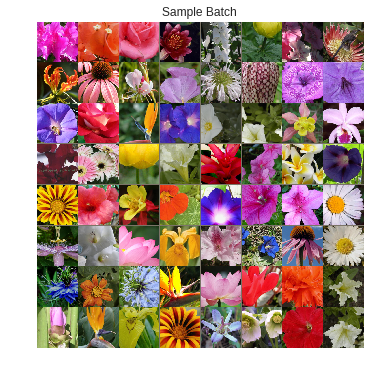

In [6]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/flower_data/'

# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.15

# create transforms
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
   ])

# train transforms
train_transforms = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10), 
      transforms.CenterCrop(350),
      transforms.ColorJitter(brightness = .1, saturation=.1),
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])    
  ])

# create dict of transforms
transforms_ = {"train": train_transforms, "test":test_transforms}

# create dict of directories
train_dir = 'train/'
valid_dir = 'valid/'
directories = {"train":train_dir, "test":valid_dir}

# create dict of classes/labels
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
num_classes = len(cat_to_name)
print(f"Number of classes: {num_classes}")

# create datasets
datasets_ = create_datasets(directories, transforms_, split=True, split_amount=.15)
train_data_idxed = [{'name':cat_to_name[str(int(x))], 'idx':i} for i,x in enumerate(datasets_['test'].classes)]

# create dataloaders
dataloaders = create_dataloaders(datasets_, batch_size)
train_dataloader = dataloaders['train']
valid_dataloader = dataloaders['valid']
test_dataloader = dataloaders['test']

# create dataset_sizes
dataset_sizes = {"train": len(train_dataloader), "valid": len(valid_dataloader), "test": len(test_dataloader)}

# display some samples
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
imshow_(torchvision.utils.make_grid(images),ax =(16,6), title="Sample Batch" )



In [7]:
# create network
model = models.resnet152(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
# resnet152: replace fc layer with our own
in_features = model.fc.in_features 
out_features = num_classes
model.fc = nn.Linear(in_features, out_features)
model.cuda()
print(model.fc) 

# define criterion, scheduler and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.0003) 
epochs = 10
save_path = data_dir+"resnet152-v1.pt"
# train the model
trained_model = train_model(dataloaders = dataloaders,
                            dataset_sizes = dataset_sizes,
                            model=model,
                            criteria=criterion,
                            optimizer=optimizer,
                            scheduler=None,
                            save_path=save_path,
                            num_epochs=epochs,
                            )



Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:04, 57189941.80it/s]


Linear(in_features=2048, out_features=102, bias=True)
[+] Training Model...
Epoch 1/10
----------
Train Loss: 277.9377 Acc: 0.0455
Epoch: 1 	Training Loss: 277.937749 	Validation Loss: 271.659396
Epoch 2/10
----------
Train Loss: 239.5556 Acc: 0.2200
Epoch: 2 	Training Loss: 239.555611 	Validation Loss: 239.895829
Epoch 3/10
----------
Train Loss: 210.1027 Acc: 0.4085
Epoch: 3 	Training Loss: 210.102665 	Validation Loss: 198.719909
Epoch 4/10
----------
Train Loss: 183.6192 Acc: 0.5434
Epoch: 4 	Training Loss: 183.619242 	Validation Loss: 207.415187
Epoch 5/10
----------
Train Loss: 159.7446 Acc: 0.6636
Epoch: 5 	Training Loss: 159.744581 	Validation Loss: 174.209773
Epoch 6/10
----------
Train Loss: 139.7995 Acc: 0.7617
Epoch: 6 	Training Loss: 139.799455 	Validation Loss: 157.606239
Epoch 7/10
----------
Train Loss: 120.2156 Acc: 0.8404
Epoch: 7 	Training Loss: 120.215605 	Validation Loss: 123.538465
Epoch 8/10
----------
Train Loss: 106.6743 Acc: 0.8597
Epoch: 8 	Training Loss: 106.

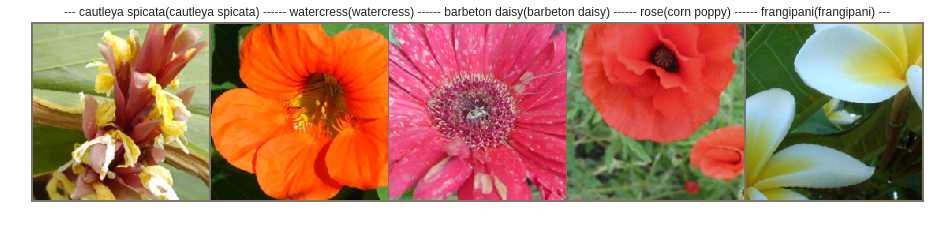

In [47]:
# predict class
preds, labels, probs, images = predict(valid_dataloader, trained_model)

# get flower names
flower_labels = []
flower_preds = []
for ii in range(len(labels)):
  flower_labels.append(train_data_idxed[labels[ii]]['name'])
  flower_preds.append(train_data_idxed[preds[ii]]['name'])

# plot our results
plot_result(flower_preds, flower_labels, images=images)
